# HW1 for MBML SF course, 1st semester.

Goal: to predict diabetes probability.


# Import библиотек.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# предварительная обработка числовых признаков
# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import MinMaxScaler
# Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import StandardScaler
# Степенное преобразование от scikit-learn
from sklearn.preprocessing import PowerTransformer
# предварительная обработка категориальных признаков
# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OneHotEncoder
# Импортируем Порядковое кодированиеот scikit-learn
from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline  # Pipeline. Ни добавить, ни убавить

from sklearn.compose import ColumnTransformer  # т.н. преобразователь колонок

# для создания собственных преобразователей / трансформеров данных
from sklearn.base import BaseEstimator, TransformerMixin

# Набор данных

Набор данных представляет собой различные показатели здоровья людей и boolean значение диабета у них.


# Загружаем данные в pandas

Данные уже были предварительно очищены от дубликатов.  
Чтобы датасет подгрузился, нужно открыть csv файл в браузере, скопировать актуальную ссылку и вставить её в параметр.


In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/synrocka/diabetes_prediction/main/data/no_dup_diabetes_prediction_db?token=GHSAT0AAAAAACPXXWHIFRA2RCQ4VA66N2RQZPZZGDQ",
    delimiter=",",
)
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
96141,Female,36.0,0,0,No Info,24.60,4.8,145,0
96142,Female,2.0,0,0,No Info,17.37,6.5,100,0
96143,Male,66.0,0,0,former,27.83,5.7,155,0
96144,Female,24.0,0,0,never,35.42,4.0,100,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96146 entries, 0 to 96145
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96146 non-null  object 
 1   age                  96146 non-null  float64
 2   hypertension         96146 non-null  int64  
 3   heart_disease        96146 non-null  int64  
 4   smoking_history      96146 non-null  object 
 5   bmi                  96146 non-null  float64
 6   HbA1c_level          96146 non-null  float64
 7   blood_glucose_level  96146 non-null  int64  
 8   diabetes             96146 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.6+ MB


# Работа с данными


Изменим тип колонок со значениями "0" и "1" на bool.


In [4]:
col_type_change_list = ["hypertension", "heart_disease", "diabetes"]
for column in df.columns:
    if column in col_type_change_list:
        df[column] = df[column].astype(bool)

Посчитаем число категориальных и числовых колонок.


In [5]:
cat_columns = []
num_columns = []

for column_name in df.columns:
    if ((df[column_name].dtypes == object) or (df[column_name].dtypes == bool)):
        cat_columns += [column_name]
    else:
        num_columns += [column_name]

print('categorical columns:\t ', cat_columns, '\n len = ', len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ', len(num_columns))

categorical columns:	  ['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes'] 
 len =  5
numerical columns:	  ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'] 
 len =  4


In [6]:
df[num_columns].describe()

,age,bmi,HbA1c_level,blood_glucose_level
count,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,27.321461,5.532609,138.218231
std,22.462948,6.767716,1.073232,40.909771
min,0.080000,10.010000,3.500000,80.000000
25%,24.000000,23.400000,4.800000,100.000000
50%,43.000000,27.320000,5.800000,140.000000
75%,59.000000,29.860000,6.200000,159.000000
max,80.000000,95.690000,9.000000,300.000000


## Очистка данных


In [7]:
df["gender"].value_counts()

Female    56161
Male      39967
Other        18
Name: gender, dtype: int64

In [8]:
df = df[(df["gender"] != "Other")]

In [9]:
df["smoking_history"].value_counts()

never          34395
No Info        32881
former          9299
current         9197
not current     6359
ever            3997
Name: smoking_history, dtype: int64

In [10]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'


df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

df['smoking_history'].value_counts()

<ipython-input-10-0833e93b77ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)


non-smoker     67276
past_smoker    19655
current         9197
Name: smoking_history, dtype: int64

In [11]:
df = df.reset_index()
df

,index,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,Female,80.0,False,True,non-smoker,25.19,6.6,140,False
1,1,Female,54.0,False,False,non-smoker,27.32,6.6,80,False
2,2,Male,28.0,False,False,non-smoker,27.32,5.7,158,False
3,3,Female,36.0,False,False,current,23.45,5.0,155,False
4,4,Male,76.0,True,True,current,20.14,4.8,155,False
...,...,...,...,...,...,...,...,...,...,...
96123,96141,Female,36.0,False,False,non-smoker,24.60,4.8,145,False
96124,96142,Female,2.0,False,False,non-smoker,17.37,6.5,100,False
96125,96143,Male,66.0,False,False,past_smoker,27.83,5.7,155,False
96126,96144,Female,24.0,False,False,non-smoker,35.42,4.0,100,False


# Предварительная обработка числовых признаков.


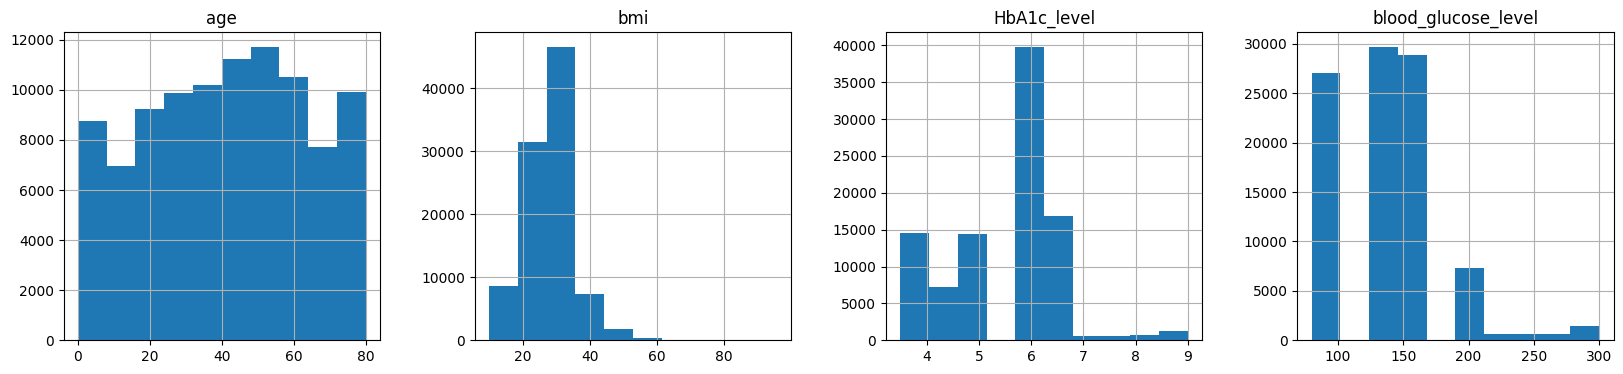

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(20,  4))

df.hist(column=num_columns, ax=axs)

# Стандартизация


## Первый шаг


In [13]:
scale = StandardScaler()

scale.fit(df[num_columns])

In [14]:
scale.mean_, scale.scale_

(array([ 41.79661743,  27.32145025,   5.53263253, 138.218001  ]),
 array([22.4632122 ,  6.76777542,  1.07321924, 40.9109769 ]))

## Шаг второй


In [15]:
scaled = scale.transform(df[num_columns])
df_standard = pd.DataFrame(scaled, columns=num_columns)
df_standard

,age,bmi,HbA1c_level,blood_glucose_level
0,1.700709,-0.314941,0.994547,0.043558
1,0.543261,-0.000214,0.994547,-1.423041
2,-0.614187,-0.000214,0.155949,0.483538
3,-0.258049,-0.572042,-0.496294,0.410208
4,1.522640,-1.061124,-0.682649,0.410208
...,...,...,...,...
96123,-0.258049,-0.402119,-0.682649,0.165775
96124,-1.771635,-1.470417,0.901370,-0.934175
96125,1.077468,0.075143,0.155949,0.410208
96126,-0.792256,1.196634,-1.428070,-0.934175


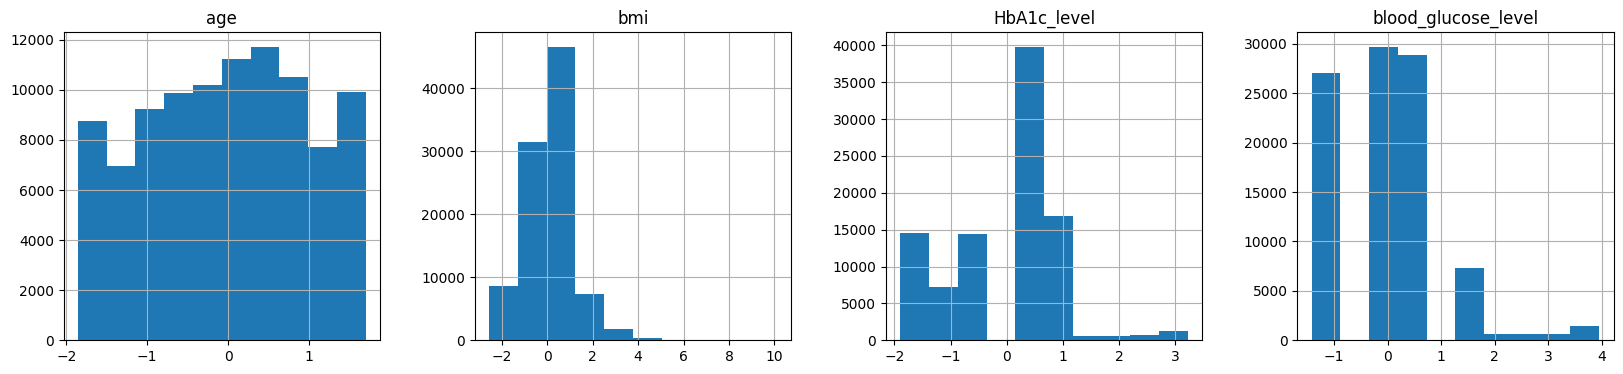

In [16]:
df_standard.hist(figsize=(20, 4), layout=(1, 4))

# Нормализация


## Первый шаг


In [17]:
norm = MinMaxScaler()

norm.fit(df[num_columns])

In [18]:
norm.data_max_, norm.data_min_

(array([ 80.  ,  95.69,   9.  , 300.  ]), array([ 0.08, 10.01,  3.5 , 80.  ]))

## Шаг второй


In [19]:
normalized = norm.transform(df[num_columns])
df_norm = pd.DataFrame(normalized, columns=num_columns)
df_norm

,age,bmi,HbA1c_level,blood_glucose_level
0,1.000000,0.177171,0.563636,0.272727
1,0.674675,0.202031,0.563636,0.000000
2,0.349349,0.202031,0.400000,0.354545
3,0.449449,0.156863,0.272727,0.340909
4,0.949950,0.118231,0.236364,0.340909
...,...,...,...,...
96123,0.449449,0.170285,0.236364,0.295455
96124,0.024024,0.085901,0.545455,0.090909
96125,0.824825,0.207983,0.400000,0.340909
96126,0.299299,0.296569,0.090909,0.090909


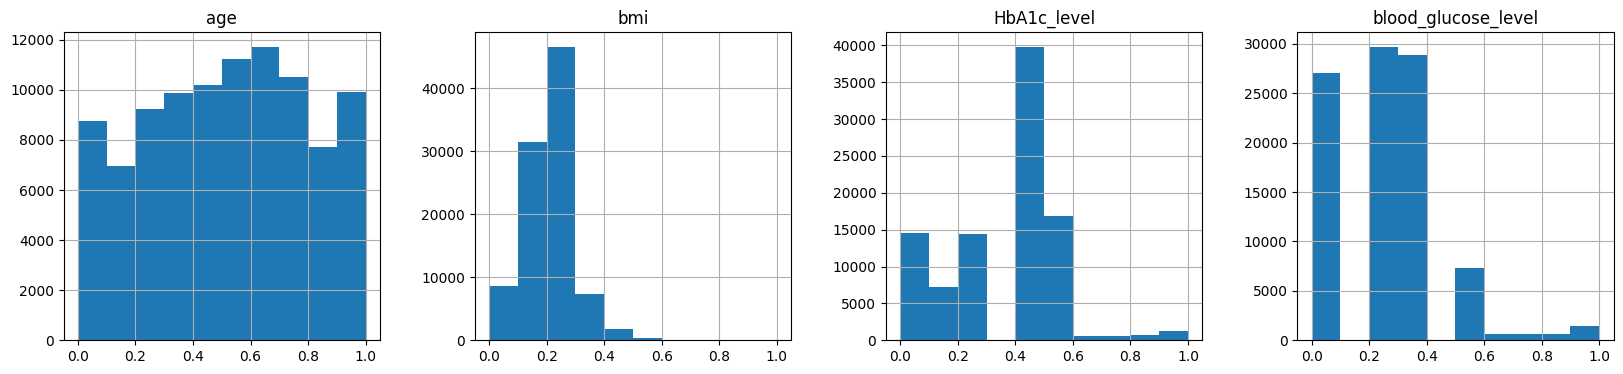

In [20]:
df_norm.hist(figsize=(20, 4), layout=(1, 4))

# Степенное преобразование


## Первый шаг


In [21]:
pt = PowerTransformer()

pt.fit(df[num_columns])

In [22]:
pt.lambdas_

array([0.81279649, 0.09125125, 1.10624566, 0.11565299])

## Шаг второй


In [23]:
power = pt.transform(df[num_columns])
df_power = pd.DataFrame(power, columns=num_columns)
df_power

,age,bmi,HbA1c_level,blood_glucose_level
0,1.594973,-0.226992,0.995667,0.172025
1,0.569328,0.106228,0.995667,-1.677277
2,-0.555715,0.106228,0.147561,0.588726
3,-0.194690,-0.518011,-0.503822,0.522274
4,1.441756,-1.127795,-0.688492,0.522274
...,...,...,...,...
96123,-0.194690,-0.323649,-0.688492,0.292290
96124,-1.943579,-1.708924,0.900880,-0.955240
96125,1.051940,0.182624,0.147561,0.522274
96126,-0.743073,1.194513,-1.420193,-0.955240


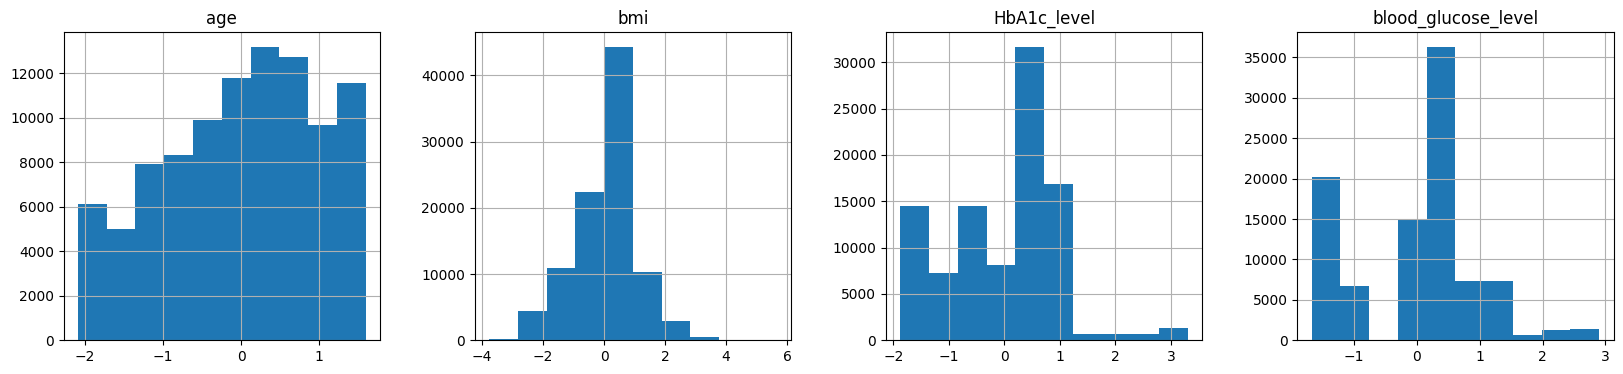

In [24]:
df_power.hist(figsize=(20, 4), layout=(1, 4))

# Создание класса для замены редких значений


In [25]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [26]:
qr = QuantileReplacer(
    threshold=0.01,
)

qr.fit(df[num_columns])

df_num_rare = qr.transform(df[num_columns])

In [27]:
df[num_columns].describe()

,age,bmi,HbA1c_level,blood_glucose_level
count,96128.000000,96128.000000,96128.000000,96128.000000
mean,41.796617,27.321450,5.532633,138.218001
std,22.463329,6.767811,1.073225,40.911190
min,0.080000,10.010000,3.500000,80.000000
25%,24.000000,23.400000,4.800000,100.000000
50%,43.000000,27.320000,5.800000,140.000000
75%,59.000000,29.860000,6.200000,159.000000
max,80.000000,95.690000,9.000000,300.000000


In [28]:
df_num_rare.describe()

,age,bmi,HbA1c_level,blood_glucose_level
count,96128.000000,96128.000000,96128.000000,96128.000000
mean,41.801091,27.619575,5.531276,138.077979
std,22.455144,6.744688,1.068959,40.388115
min,1.000000,14.550000,3.500000,80.000000
25%,24.000000,23.630000,4.800000,100.000000
50%,43.000000,27.320000,5.800000,140.000000
75%,59.000000,30.120000,6.200000,159.000000
max,80.000000,48.974600,8.800000,280.000000


# Работа с категориальными признаками


## Порядковое кодирование


### Первый шаг


In [29]:
ordinal = OrdinalEncoder()

ordinal.fit(df[cat_columns])

In [30]:
ordinal.categories_

[array(['Female', 'Male'], dtype=object),
 array([False,  True]),
 array([False,  True]),
 array(['current', 'non-smoker', 'past_smoker'], dtype=object),
 array([False,  True])]

### Шаг второй


In [31]:
ordinal_encoded = ordinal.transform(df[cat_columns])

df_ordinal = pd.DataFrame(ordinal_encoded, columns=cat_columns)
df_ordinal

,gender,hypertension,heart_disease,smoking_history,diabetes
0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...
96123,0.0,0.0,0.0,1.0,0.0
96124,0.0,0.0,0.0,1.0,0.0
96125,1.0,0.0,0.0,2.0,0.0
96126,0.0,0.0,0.0,1.0,0.0


## One-hot кодирование многозначных признаков.


### Первый шаг


In [34]:
ohe = OneHotEncoder(
    drop='if_binary', handle_unknown='ignore', sparse_output=False)

ohe.fit(df[cat_columns])

In [35]:
ohe.categories_

[array(['Female', 'Male'], dtype=object),
 array([False,  True]),
 array([False,  True]),
 array(['current', 'non-smoker', 'past_smoker'], dtype=object),
 array([False,  True])]

In [36]:
ohe_feat = ohe.transform(df[cat_columns])

df_ohe = pd.DataFrame(
    ohe_feat, columns=ohe.get_feature_names_out()).astype(int)
df_ohe

,gender_Male,hypertension_True,heart_disease_True,smoking_history_current,smoking_history_non-smoker,smoking_history_past_smoker,diabetes_True
0,0,0,1,0,1,0,0
1,0,0,0,0,1,0,0
2,1,0,0,0,1,0,0
3,0,0,0,1,0,0,0
4,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...
96123,0,0,0,0,1,0,0
96124,0,0,0,0,1,0,0
96125,1,0,0,0,0,1,0
96126,0,0,0,0,1,0,0


# Pipeline


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96128 entries, 0 to 96127
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                96128 non-null  int64  
 1   gender               96128 non-null  object 
 2   age                  96128 non-null  float64
 3   hypertension         96128 non-null  bool   
 4   heart_disease        96128 non-null  bool   
 5   smoking_history      96128 non-null  object 
 6   bmi                  96128 non-null  float64
 7   HbA1c_level          96128 non-null  float64
 8   blood_glucose_level  96128 non-null  int64  
 9   diabetes             96128 non-null  bool   
dtypes: bool(3), float64(3), int64(2), object(2)
memory usage: 5.4+ MB


In [43]:
cat_pipe_gender_hypertension_heart_diabetes = Pipeline([("encoder", OrdinalEncoder())])
cat_gender = ["gender", "hypertension", "heart_disease", "diabetes"]

In [63]:
cat_pipe_smoking = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary',
     handle_unknown='ignore', sparse_output=False))
])
cat_smoking = ['smoking_history']

In [45]:
num_pipe_age_bmi_HbA1c_glucose = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('power', PowerTransformer())
])
num_age_bmi_HbA1c_glucose = ['age', 'bmi',
                             'HbA1c_level', 'blood_glucose_level']

## Объединяем


In [64]:
preprocessors = ColumnTransformer([
    ('cat_gender_hypertension_heart_diabetes',
     cat_pipe_gender_hypertension_heart_diabetes, cat_gender),
    ('cat_smoking', cat_pipe_smoking, cat_smoking),
    ('num_pipe_age_bmi_HbA1c_glucose',
     num_pipe_age_bmi_HbA1c_glucose, num_age_bmi_HbA1c_glucose)
])

In [65]:
preprocessors

ColumnTransformer(transformers=[('cat_gender_hypertension_heart_diabetes',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder())]),
                                 ['gender', 'hypertension', 'heart_disease',
                                  'diabetes']),
                                ('cat_smoking',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['smoking_history']),
                                ('num_pipe_age_bmi_HbA1c_glucose',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('power',
                                                  PowerTransformer())]),
                                 ['age', 'bmi', 'HbA1c_level',
                                  'blood_glucose_level'])])

In [66]:
preprocessors.fit(df)

## Достаем признаки и объединяем в датафрейм


In [68]:
preprocessors.transformers_[1][1]["encoder"].get_feature_names_out()

array(['smoking_history_current', 'smoking_history_non-smoker',
       'smoking_history_past_smoker'], dtype=object)